# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

# Data

In [4]:
preferences_data = pd.read_excel('data/Preferences.xlsx', sheet_name='DM Preferences')

In [5]:
criteria_values = preferences_data[['distance', 'max_workload', '#changed offices']].values
rankings = preferences_data['rank'].values

In [9]:
print(criteria_values)

[[ 83.7222536    1.06635769   1.        ]
 [ 86.06487029   1.12324265   0.        ]
 [ 89.6639451    1.11419638   1.        ]
 [ 80.18637567   1.22684437   1.        ]
 [ 79.22761378   1.18049994   2.        ]
 [ 75.21489302   1.40483011   0.        ]
 [ 83.30801015   1.47108284   0.        ]
 [ 82.39731414   1.40964798   1.        ]
 [ 81.46646041   1.02921185   4.        ]
 [ 91.78442093   1.08713063   3.        ]
 [103.31869586   1.22381242   0.        ]
 [ 94.12387853   1.30654991   0.        ]
 [117.85792847   1.03242009   2.        ]
 [ 88.98791323   1.26218968   2.        ]
 [ 76.43830663   1.29014786   3.        ]
 [185.90059899   1.10404998   1.        ]
 [ 91.24773431   1.40160377   2.        ]
 [101.50924779   1.18227143   3.        ]
 [118.22552192   1.26511839   1.        ]
 [110.22721834   1.3274603    1.        ]
 [139.69758501   1.03614225   3.        ]
 [129.53077717   1.17472727   2.        ]
 [129.11889303   1.18579896   2.        ]
 [116.87062859   1.17204803   3.  

In [8]:
print(rankings)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


## Definition of Pairwise Ranking Set:

$$ P = \{ (r_i, r_j) \mid i < j \} $$

where $i < j$ ensures that only pairs where $i$ is ranked better than $j$ are included.  

In [10]:
rank_indices = [rank - 1 for rank in rankings]
pairwise_rankings = [(rank_indices[i], rank_indices[j]) for i in range(len(rank_indices)) for j in range(i + 1, len(rank_indices))]

In [12]:
non_dominated_solutions_df = pd.read_csv("data/triobjective_nondominated_solutions.csv")

In [13]:
non_dominated_solutions_df.head()

,solution_id,distance,max_workload,relocated_offices
0,0,154.615221,1.12,0
1,1,156.707324,1.09,0
2,2,162.630563,1.08,0
3,3,166.533555,1.05,0
4,4,177.377370,1.04,0


In [14]:
non_dominated_solutions = non_dominated_solutions_df.iloc[:, 1:].values

In [19]:
non_dominated_solutions.shape

(29, 3)

# UTA

In [11]:
bricks = range(22)
SRs = range(4)

In [20]:
n_criteria = non_dominated_solutions.shape[1]
n_alternatives = len(criteria_values)
epsilon_mono = 1e-4
epsilon_rank = 1e-4
L_max = 10
breakpoints = {i: np.linspace(min(criteria_values[:, i]), max(criteria_values[:, i]), L_max) for i in range(n_criteria)}

In [23]:
def calculate_solution_u(solution, piecewise_u, breakpoints, n_criteria):
    total_u = 0
    for i in range(n_criteria):
        for j in range(len(breakpoints[i]) - 1):
            if breakpoints[i][j] <= solution[i] < breakpoints[i][j + 1]:
                slope = (piecewise_u[i][j + 1] - piecewise_u[i][j]) / (
                    breakpoints[i][j + 1] - breakpoints[i][j]
                )
                total_u += piecewise_u[i][j] + slope * (solution[i] - breakpoints[i][j])
    return total_u

In [24]:
model = Model("UTA")

u = {i: model.addVars(n_alternatives, lb = 0, ub= 1/n_criteria, name = f"u_{i}") for i in range(n_criteria)}
sigma_plus = model.addVars(n_alternatives, lb = 0, name="sigma_plus")
sigma_minus = model.addVars(n_alternatives, lb = 0, name="sigma_minus")

# Normalization constraints
for i in range(n_criteria):
    model.addConstr(u[i][0] == 0, name=f"u_min_{i}")
    model.addConstr(u[i][n_alternatives - 1] == 1/n_criteria, name=f"u_max_{i}")
    for k in range(n_alternatives - 1):
        model.addConstr(u[i][k + 1] - u[i][k] >= epsilon_mono, name=f"Piecewise_{i}_{k}")  # ensures monotonicity

# Ranking constraints
for better, worse in pairwise_rankings:
    better_u = quicksum(
        u[i][j] * (criteria_values[better, i] - breakpoints[i][j])
        for i in range(n_criteria)
        for j in range(len(breakpoints[i]) - 1)
        if breakpoints[i][j] <= criteria_values[better, i] < breakpoints[i][j + 1]
    )
    worse_u = quicksum(
        u[i][j] * (criteria_values[worse, i] - breakpoints[i][j])
        for i in range(n_criteria)
        for j in range(len(breakpoints[i]) - 1)
        if breakpoints[i][j] <= criteria_values[worse, i] < breakpoints[i][j + 1]
    )
    model.addConstr(
        better_u + sigma_minus[better] - sigma_plus[better]
        >= worse_u + sigma_minus[worse] - sigma_plus[worse] + epsilon_rank,
        name=f"Strict_Preference_{better}_{worse}",
    )

model.setObjective(quicksum(sigma_plus[j] + sigma_minus[j] for j in range(n_alternatives)), GRB.MINIMIZE)

model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 861 rows, 195 columns and 6661 nonzeros
Model fingerprint: 0x4e83f891
Coefficient statistics:
  Matrix range     [7e-04, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e-01, 3e-01]
  RHS range        [1e-04, 3e-01]
Presolve removed 106 rows and 102 columns
Presolve time: 0.01s
Presolved: 755 rows, 93 columns, 5919 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.050957e-01   0.000000e+00      0s
     144    9.8828071e-02   0.000000e+00   0.000000e+00      0s

Solved in 144 iterations and 0.02 seconds (0.01 work units)
Optimal objective  9.882807106e-02


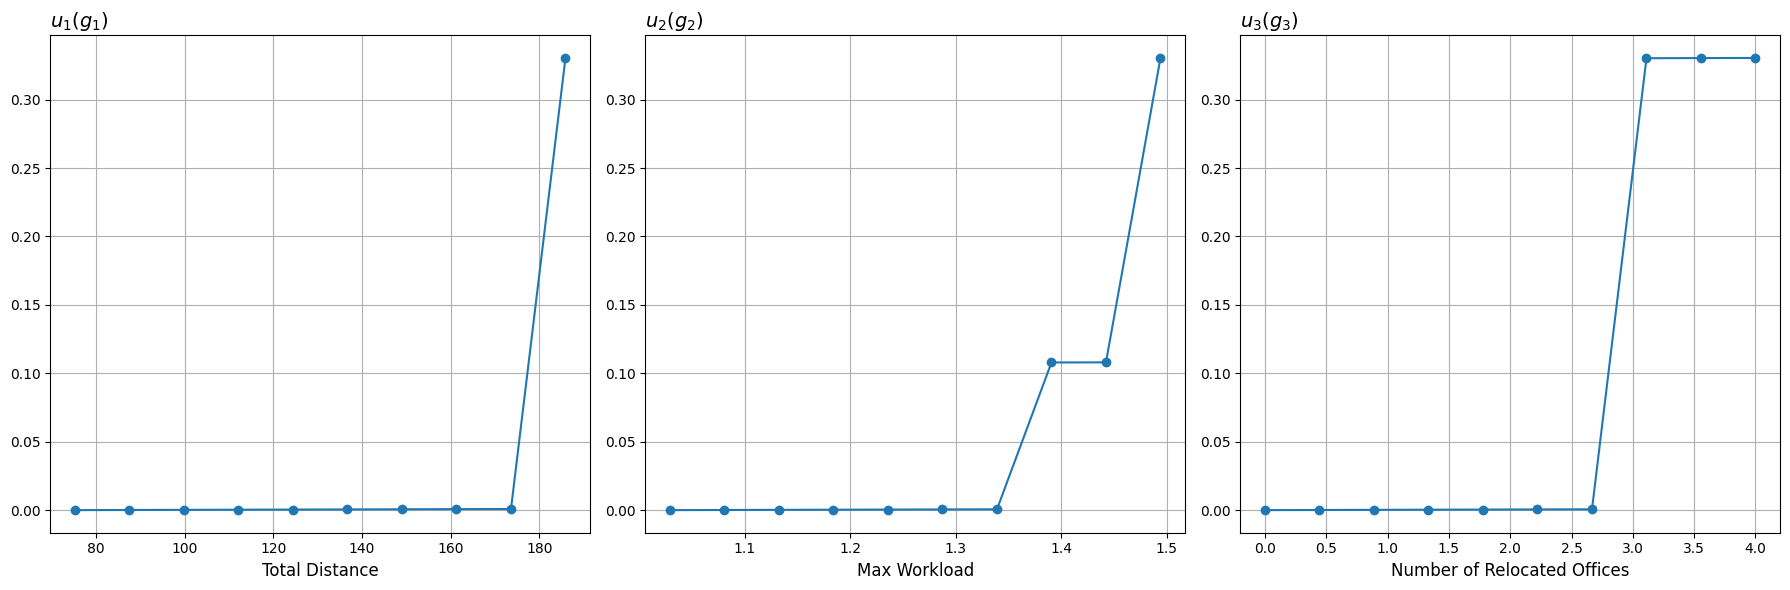

All solutions and their utilities:
Solution: [154.61522149   1.12         0.        ], Utility: 0.0008
Solution: [156.707324   1.09       0.      ], Utility: 0.0008
Solution: [162.63056342   1.08         0.        ], Utility: 0.0008
Solution: [166.53355458   1.05         0.        ], Utility: 0.0008
Solution: [177.37736973   1.04         0.        ], Utility: 0.1020
Solution: [182.83943561   1.01         0.        ], Utility: 0.2484
Solution: [106.71323272   1.12         1.        ], Utility: 0.0007
Solution: [108.80533523   1.09         1.        ], Utility: 0.0006
Solution: [112.62476119   1.08         1.        ], Utility: 0.0006
Solution: [112.91619976   1.05         1.        ], Utility: 0.0006
Solution: [114.94458094   1.01         1.        ], Utility: 0.0005
Solution: [105.05653001   1.1149       2.        ], Utility: 0.0009
Solution: [107.14863252   1.0866       2.        ], Utility: 0.0008
Solution: [110.13089795   1.0706       2.        ], Utility: 0.0008
Solution: [111.0750

In [25]:
if model.status == GRB.OPTIMAL:
    piecewise_u = {}
    for i in range(n_criteria):
        piecewise_u[i] = [u[i][j].X for j in range(len(breakpoints[i]))]

    # Plot piecewise functions
    fig, axes = plt.subplots(1, n_criteria, figsize=(18, 6))
    for i, ax in enumerate(axes):
        ax.plot(breakpoints[i], piecewise_u[i], marker="o")
        ax.set_xlabel(["Total Distance", "Max Workload", "Number of Relocated Offices"][i], fontsize=12)
        ax.set_title(f"$u_{i+1}(g_{i+1})$", fontsize=14, loc='left')
        ax.grid(True)
    plt.tight_layout()
    plt.show()

    solution_u = [
        (solution, calculate_solution_u(solution, piecewise_u, breakpoints, n_criteria))
        for solution in non_dominated_solutions
    ]

    print("All solutions and their utilities:")
    for solution, utility in solution_u:
        print(f"Solution: {solution}, Utility: {utility:.4f}")

    best_solution = max(solution_u, key=lambda x: x[1])
    print(f"Best solution: {best_solution[0]} with utility: {best_solution[1]:.4f}")
    
else:
    print("No optimal solution found for UTA.")